## Работа с картами в рамках оцифровки

Важное уточнение: необходимо использовать карту без легенды (превдарительно обрезаем её). Я это сделала не внутри кода, а через графический редактор. Сам код выполняется не быстро, распознавание текстовых глубин занимает большую часть времени. Обращу внимание, что код выполнялся в Google Collab, после каждой ячейки, которая предполагала какой-либо вывод изображения, я вставляла скриншот этого полученного изображения. Скрипт прогонялся на изображении "Приложение 3.jpg".  

По коду/по тексту у меня может встречаться вместо "глубины" слово "высота". Также под переменной `height` понимайте, пожалуйста, глубину, а не высоту

In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 23.9 MB/s eta 0:00:00


In [ ]:
!pip install pytesseract

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import sys
import easyocr
import pytesseract
from PIL import Image
from collections import defaultdict
from scipy.spatial import KDTree

## Этап 1 – выделяем цвета:
* Выделение всех RGB кластеров
* Группировка близких цветов

In [ ]:
def remove_river(img_bgr):

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) #из BGR преобразую в HSV, так как при выделении цветов по оттенку лучше работать с этим цветовым пространсвтвом

    #на карте есть речка и много маленьких, пока просто создадим маску по ним по похожему цвету, зная, что они голубая
    #в HSV первый элемент это оттенок, второй - насыщенность, третий - яркость
    lower_cyan = np.array([60, 20, 60])
    upper_cyan = np.array([130, 255, 255])
    river_mask = cv2.inRange(hsv, lower_cyan, upper_cyan)

    #раздуваем маску, чтобы удалить точно все артефакты реки
    kernel = np.ones((5, 5), np.uint8)
    river_mask = cv2.dilate(river_mask, kernel, iterations=3)

    #заполняем области, отмеченные маской, цветом соседних пикселей
    img_inpainted = cv2.inpaint(
        img_bgr,
        river_mask,
        40, #попробую использовать 40 соседних пикселей (можно уменьшить, чтобы код выполнялся быстрее)
        cv2.INPAINT_TELEA #один из алгоритмов заполнения
    )

    return img_inpainted

In [ ]:
def process_geological_map(image_path, k_colors=12):
    img_bgr = cv2.imread(image_path)

    img_clean = remove_river(img_bgr)

    #теперь удалим вспомогательные линии и сгладим карту, так как нужно собрать цвета основных геозон
    img_no_lines = cv2.medianBlur(img_clean, 45) #параметры подбирала эмпирически
    img_smooth = cv2.bilateralFilter(img_no_lines, 9, 75, 75)
    cv2.imwrite("cleaned_heatmap.png", img_smooth)

    #чтобы фон (белый цвет) не воспринимался как кластер
    img_rgb = cv2.cvtColor(img_smooth, cv2.COLOR_BGR2RGB) #в обычном RGB удобнее работать
    background_mask = np.all(img_rgb == [255, 255, 255], axis=2) #маска белого фона
    np.save("background_mask.npy", background_mask)

    #применяем K-Means, причем берем пиксели не фона
    pixels = img_rgb.reshape(-1, 3)
    mask_flat = (~background_mask).reshape(-1)
    pixels_fg = pixels[mask_flat]
    pixels_fg = np.float32(pixels_fg) #важно для KMeans согласно OpenCV документации

    sample_size = int(pixels_fg.shape[0] * 0.15) #беру 15% пикселей, чтобы ускорить кластеризацию
    sample_pixels = pixels_fg[np.random.choice(pixels_fg.shape[0], sample_size, replace=False)]

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2) #критерий остановки с eps=0.2, макс итераций = 100
    _, labels, centers = cv2.kmeans(sample_pixels, k_colors, None, criteria, 15, cv2.KMEANS_RANDOM_CENTERS) #кол-во запусков можно уменьшить, чтобы снизить время выполнения кода
    centers = np.uint8(centers) #для совместимости с OpenCV

    #теперь составлю карту, которая состоит только из цветов цендроидов
    pixels_fg_float = pixels_fg.astype(np.float32)
    centers_float = centers.astype(np.float32)

    #вычисляем расстояния от каждого пикселя до всех центроидов:
    diff = pixels_fg_float[:, None, :] - centers_float[None, :, :]
    dists = np.sum(diff ** 2, axis=2) #суммируем квадраты разностей по каналам RGB
    nearest_idx = np.argmin(dists, axis=1)  #нахожу индекс ближайшего центроида для каждого пикселя

    #заменяем цвета пикселей на цвета центроидов
    quantized_rgb = img_rgb.copy().reshape(-1, 3)
    quantized_rgb[mask_flat] = centers[nearest_idx]
    quantized_rgb = quantized_rgb.reshape(img_rgb.shape)

    quantized_bgr = cv2.cvtColor(quantized_rgb, cv2.COLOR_RGB2BGR)

    cv2.imwrite("cleaned_heatmap.png", img_smooth)

    cv2.imwrite("cleaned_heatmap_quantized.png", quantized_bgr)

    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.title("Оригинал")
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Очищенная карта")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Карта центроидов")
    plt.imshow(quantized_rgb)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return centers

In [ ]:
centers = process_geological_map("Приложение 3 без легенды.jpg", k_colors=20)

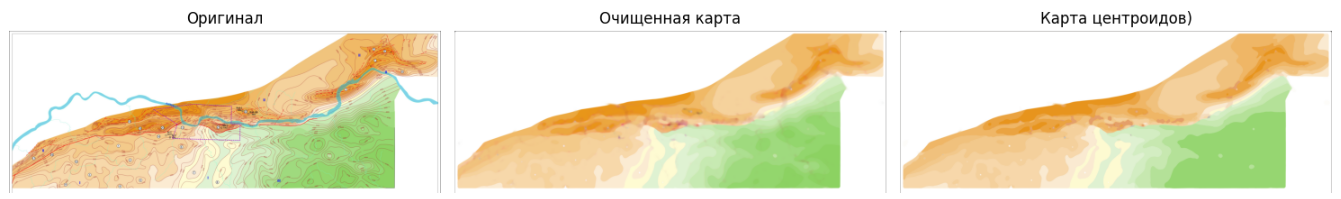

In [ ]:
def plot_palette(colors, rows=4, cols=5):

    fig, axes = plt.subplots(rows, cols, figsize=(16, 5))
    axes_flat = axes.flatten()
    #нарисуем квадрат цвета каждого центроида
    for i, ax in enumerate(axes_flat):
        if i < len(colors):
            rgb = colors[i]
            normalized_color = [x / 255.0 for x in rgb]
            rect = plt.Rectangle((0, 0), 1, 1, color=normalized_color)
            ax.add_patch(rect)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.suptitle("Палитра цветов геологических зон")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_palette(centers)

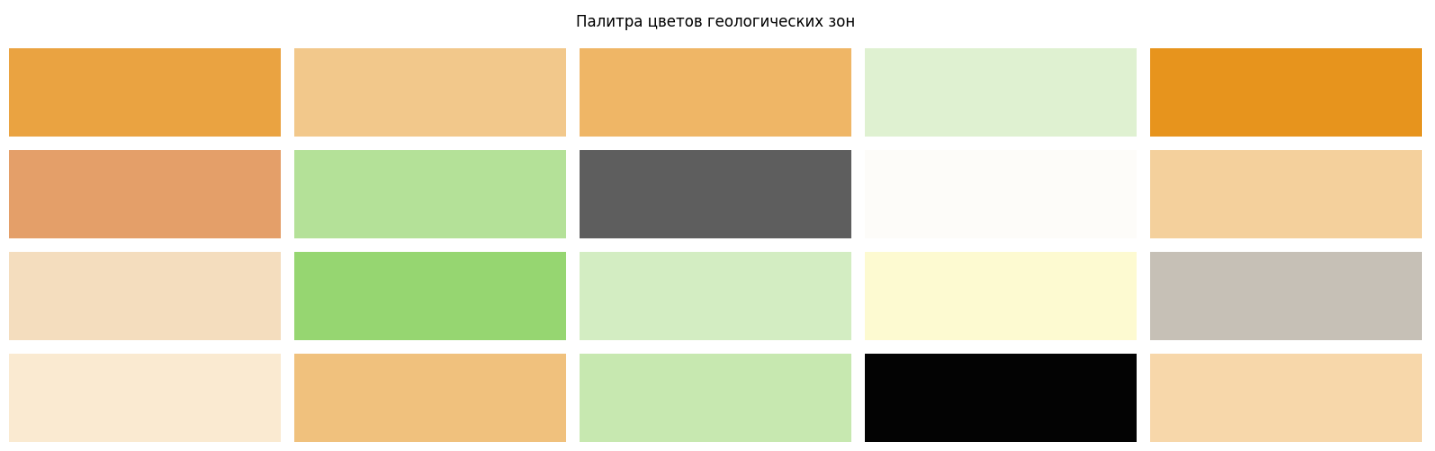

## Этап 2 – прочитать глубины

Сначала создадим несколько вариантов одной и той же карты с разными настройками улучшения контраста и масштабирования, чтобы повысить точность OCR для цифр на карте



Работаем с контрастом (CLAHE)

In [ ]:
def apply_clahe_rgb(image_bgr, clip_limit, tile_grid_size):
    b, g, r = cv2.split(image_bgr)

    #обрабатываем каждый канал отдельно
    channels_out = []
    for ch in (r, g, b): #работаем с цветами в порядке rgb
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        ch_enh = clahe.apply(ch)
        channels_out.append(ch_enh)

    rgb = cv2.merge((channels_out[0], channels_out[1], channels_out[2]))
    return rgb

Работаем с масштабом

In [ ]:
def scale_image(image, scale):
    h, w = image.shape[:2]
    new_w = int(w * scale)
    new_h = int(h * scale)
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC) #я пробую кубическую интерполяцию в окрестности 4×4 пикселей, но можно и другие затестить

Теперь функция именно для создадния вариантов с разными параметрами

In [ ]:
def generate_preprocessing_variants(img_bgr):
    variants = []

    for cl in [1.0, 2.0, 2.5, 3.0, 4.0]: #с этим можно поиграть, попробовать перебирать еще параметры, чтобы числа были более доступны для распознавания
        rgb_clahe = apply_clahe_rgb(img_bgr, cl, (8, 8))
        variants.append((f"clahe{cl}_1x", rgb_clahe, 1.0)) #создала 5 вариантов с разным clipLimit

    rgb_clahe_25 = apply_clahe_rgb(img_bgr, 2.5, (8, 8)) #еще создам 2 варианта с clipLimit=2.5, но разным масштабом
    for scale in [1.5, 2.0]:
        rgb_scaled = scale_image(rgb_clahe_25, scale)
        variants.append((f"clahe2.5_{scale}x", rgb_scaled, scale))

    return variants

In [ ]:
def save_all_preprocessed_versions(image, output_dir="preprocessed_variants"):

    #читаем оригинал
    img_bgr = cv2.imread(image)

    #для отладки решения я создала директорию, в которую сохраняются все предобработанные карты
    os.makedirs(output_dir, exist_ok=True)

    #генерируем все варианты предобработки
    variants = generate_preprocessing_variants(img_bgr)

    #сохраняем все карты с понятным названием в папку
    for i, (name, img_var_rgb, scale) in enumerate(variants, 1):

        out_bgr = cv2.cvtColor(img_var_rgb, cv2.COLOR_RGB2BGR)
        out_name = os.path.join(output_dir, f"{i:02d}_{name}.png")
        cv2.imwrite(out_name, out_bgr)

In [ ]:
save_all_preprocessed_versions("Приложение 3 без легенды.jpg", output_dir="preproc_OCR_variants")

Наконец сам блок с чтением глубин с карты

Вход: 2 изображения (Оригинал (с числами) + очищенная карта только с цветами)  
Предобработка  
OCR: EasyOCR + Tesseract  
Локальное вращение для улучшения  
Фильтрация и удаление дубликатов  
Выход: Соответствие ЦВЕТ → ГЛУБИНА


EasyOCR может упасть по множеству причин, как и Tesseract, поэтому далее в функциях я прописывала блоки try-except

In [ ]:
def run_easyocr(reader, image_rgb):
    try:
        return reader.readtext(image_rgb)
    except Exception as e:
        print(f"Ошибка: {e}")
        return []

  **Конфигурация Tesseract**
  
  **psm**  
  0    Orientation and script detection (OSD) only.  
  1    Automatic page segmentation with OSD.  
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)  
  3    Fully automatic page segmentation, but no OSD. (Default)  
  4    Assume a single column of text of variable sizes.  
  5    Assume a single uniform block of vertically aligned text.  
  6    Assume a single uniform block of text.  
  7    Treat the image as a single text line.  
  8    Treat the image as a single word.  
  9    Treat the image as a single word in a circle.  
 10    Treat the image as a single character.  
 11    Sparse text. Find as much text as possible in no particular order.  
 12    Sparse text with OSD.  
 13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.  

**oem**  
0 = Original Tesseract only.  
1 = Neural nets LSTM only.  
2 = Tesseract + LSTM.  
3 = Default, based on what is available.  

Запуск Tesseract OCR. Так как значения глубин на карте представляют собой одинаковые блоки текста, использую psm 6.  
oem 3 беру по умолчанию

In [ ]:
def run_tesseract_psm6(image_rgb):
    try:
        pil_img = Image.fromarray(image_rgb) #Tesseract работает с PIL изображениями
        config = "--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789" #тут указала, что работаем только с этими цифрами

        data = pytesseract.image_to_data(pil_img, config=config, output_type=pytesseract.Output.DICT)

        out = []
        n = len(data["text"]) #это как раз количество обнаруженных текстовых элементов

        #цикл по всем обнаруженным элементам
        for i in range(n):
            txt = data["text"][i].strip()

            if not txt:
                continue #пустые строки пропускаем

            try:
                conf_val = float(data["conf"][i]) #это уверенность распознавания
            except ValueError:
                continue

            if conf_val < 0: #если уверенность -1, это значит, что не распознано, пропускаю такие
                continue

            conf = conf_val / 100.0 #для согласованности с EasyOCR переведу уверенность в диапазон 0-1

            #теперь определяю прямоугольник вокруг текста
            x, y, w, h = (
                data["left"][i],
                data["top"][i],
                data["width"][i],
                data["height"][i])
            bbox = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.float32)

            out.append((bbox, txt, conf))
        return out
    except Exception as e:
        print(f"Tesseract psm6 ошибка: {e}")
        return []

Теперь функция, котрая вращает патч вокруг найденного текста, чтобы корректно распознавать перевернутое чичло

In [ ]:
def refine_height_by_rotation(img_bgr, cx, cy, box_size, reader, angle_step=20):

    h, w = img_bgr.shape[:2] #высота и ширина изображения

    #создаю квадратную область вокруг точки (cx, cy) - это координаты центра предполагаемой цифры
    half = box_size // 2
    x1 = max(0, cx - half)
    y1 = max(0, cy - half)
    x2 = min(w, cx + half)
    y2 = min(h, cy + half)

    patch_bgr = img_bgr[y1:y2, x1:x2] #это мой вырезанный патч изображения
    if patch_bgr.size == 0:
        return None, None

    #определяю высоту, ширину, центр
    ph, pw = patch_bgr.shape[:2]
    center = (pw // 2, ph // 2)
    patch_rgb = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2RGB)

    freq = defaultdict(int) #сколько раз этот текст распознался
    best_conf_for_text = defaultdict(float) #сюда запишу лучшую уверенность для текста

    for angle in range(0, 360, angle_step):
        M = cv2.getRotationMatrix2D(center, angle, 1.0) #создаю матрицу аффинного преобразования без изменения масштаба
        rotated = cv2.warpAffine(patch_rgb, M, (pw, ph), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        #выше я поворачиваю патч на матрицу вращения M с размером выходного изображения (pw, ph). использую тут кубическую интерполяцию (вроде она самая качесвтенная), а границы заполняю, копируя крайние пиксели
        try:
            ocr_res = reader.readtext(rotated) #тут пробую EasyOCR
        except Exception:
            continue

        for (bbox_r, text_r, conf_r) in ocr_res:
            digits = "".join(c for c in text_r if (c.isdigit() or c == ".")) #из прочитанного текста сохраняем только цифры и точки (я подумала, что вдргу на карте встретится не целое число)
            digits = digits.strip(".")
            #пустые строки, строки меньше 2 знаков или более 5 знаков не рассматриваю
            if not digits or len(digits) < 2:
                continue
            if len(digits) > 5:
                continue

            #выше я создала словари - теперь плюсуем счетчик для этого текста и обновляем максимальную уверенность
            freq[digits] += 1
            if conf_r > best_conf_for_text[digits]:
                best_conf_for_text[digits] = conf_r

    if not freq: #заглушка, если ни один угол поворота не дал результатов
        return None, None


    #на картах у нас преобладают четырехзначные числа (по моим наблюдениям), но конечно это пока тестовый вариант, в дальнейшем можно выработать более универсальный подход
    #сначала ищем четырехзначные числа, если они есть - рассматриваем только их, если нет - рассматриваем все кандидаты
    four_digit = {t: c for t, c in freq.items() if len(t) == 4}
    candidates = four_digit if four_digit else freq

    best_text = None
    best_count = -1
    best_conf = -1.0

    for t, cnt in candidates.items():
        conf_t = best_conf_for_text.get(t, 0.0)
        #что распозналось чаще или если распознаваемость одинаковая, то в чем более уверены
        if cnt > best_count or (cnt == best_count and conf_t > best_conf):
            best_text = t
            best_count = cnt
            best_conf = conf_t

    if best_text is None:
        return None, None

    try:
        best_height = float(best_text)
    except ValueError:
        return None, None

    return best_height, best_text

Какие-то значения глубин функциями выше мы получим, но в данном случае нужно убедиться, реалистичны ли эти значения. Функция `is_realistic_height` вернет True если высота реалистична, False если нет



In [ ]:
def is_realistic_height(height_val, num_digits, confidence):
    if not (500 <= height_val <= 8000): #нижняя и верхняя границы (их можно поменять в зависимости от карты. в данной функции все равно отбрасываются все 2-значные числа (см. последний if))
        return False
    if num_digits == 4: #для 4-значных чисел хочу минимальную уверенность 15%
        if confidence < 0.15:
            return False
        return True
    if num_digits == 3: #для 3-значных хочу минимум 30% уверенности, потому что они вряд ли могут встретиться
        if confidence < 0.3:
            return False
        return True
    if num_digits == 2: #2-значные числа всегда отбрасываю
        return False
    return True

#все пороги уверенности можно адаптировать под разные виды карт, просто те карты, которые были предложены, имеют в основном четырехзначные глубины
#но в целом это очень адаптивная история, если в дальнейшем использовать скрипт внутри какого-то интструмента, то можно отдать пользователю возможность
#вводить в интерфейсе минимальную/максимальную глубины или их значность

Далее я написала функцию (на всякий случай) - она определяет, находится ли цифра на белом фоне, чтобы исключить её из результатов на случай, если мы найдем какие-то "глубины", написанные на фоне

In [ ]:
def is_background_white(color_rgb, white_threshold=253):
    r, g, b = color_rgb
    return r > white_threshold and g > white_threshold and b > white_threshold

Далее представлена функция, которая убирает дубликаты. Это обрабатывается случай, когда одна и та же глубина распознана несколько раз разными OCR-движками или вариантами предобработки

In [ ]:
def dedup_by_proximity(detections, grid_size=50): #grid_size можно попоробовать подобрать другой, потому что на итоговом изображении заметно, что некоторые глубины распознались несколько раз

    '''
    Идея:
    Создаём словарь для группировки детекций по ячейкам сетки
    Ключ: (grid_x, grid_y) - координаты ячейки
    Значение: список детекций, попавших в эту ячейку
    '''
    grid = defaultdict(list)

    for det in detections:
        x = det["x"] #берем координаты центра детекции
        y = det["y"]
        grid_x = x // grid_size #вычисляем ячейку сетки
        grid_y = y // grid_size
        key = (grid_x, grid_y)
        grid[key].append(det) #добавляем детекцию в соответствующую ячейку сетки (в словаре)

    deduped = []
    for cell_dets in grid.values():
        if len(cell_dets) == 1: #если 1 ячейка=1 детекция, то ее и оставляем
            deduped.append(cell_dets[0])
        else:
            best = max(cell_dets, key=lambda x: x["confidence"]) #а иначе оставляем детекцию с максимальной уверенностью
            deduped.append(best)

    return deduped

Далее объединяю все предыдущие функции в единый процесс:  
1. Загрузка двух изображений
2. Создаем 7 вариантов изображения карты
3. Двойной OCR (EasyOCR + Tesseract) на всех вариантах
4. Фильтрация и улучшение (вращение)
5. Определение цвета области
6. Удаление дубликатов в ячейке
7. Создание маппинга

In [ ]:
def extract_map_colors_and_heights(image_original_path, image_cleaned_path):

    img_original_bgr = cv2.imread(image_original_path) #оригинал
    img_cleaned_bgr = cv2.imread(image_cleaned_path) #карта только с геозонами

    img_original_rgb = cv2.cvtColor(img_original_bgr, cv2.COLOR_BGR2RGB)

    variants = generate_preprocessing_variants(img_original_bgr) #сгенерировали все варианты карты

    reader = easyocr.Reader(["en", "ru"], gpu=False) #создаем экземпляр EasyOCR

    all_results = []
    for var_idx, (name, img_var_rgb, scale) in enumerate(variants, 1):

        #EasyOCR
        res_e = run_easyocr(reader, img_var_rgb)
        for (bbox, text, conf) in res_e:
            all_results.append({
                "bbox": np.array(bbox, dtype=np.float32),
                "text": text,
                "conf": float(conf),
                "engine": "EasyOCR",
                "variant": name,
                "scale": scale,
            })

        #Tesseract
        res_t6 = run_tesseract_psm6(img_var_rgb)
        for (bbox, text, conf) in res_t6:
            all_results.append({
                "bbox": np.array(bbox, dtype=np.float32),
                "text": text,
                "conf": float(conf),
                "engine": "Tesseract_psm6",
                "variant": name,
                "scale": scale,
            })

    color_to_height = {} #словарь для финального соответсвия цвет - высота
    seen_keys = set() #это для отслеживания уже обработанных комбинаций глубины и координат, чтобы хоть немного ускорить процесс
    detections = []

    h0, w0 = img_original_rgb.shape[:2]
    raw_detections = []

    #изучаю каждую распознанную глубину
    for res in all_results:
        text = res["text"]
        conf = res["conf"]
        engine = res["engine"]
        variant = res["variant"]
        scale = res["scale"]
        bbox = res["bbox"]

        if conf < 0.10: #если уверенность меньше 0.10, то не беру эту глубину
            continue

        #для масштабированных вариантов координаты нужно вернуть к исходному масштабу
        cx_pre = float(np.mean(bbox[:, 0]))
        cy_pre = float(np.mean(bbox[:, 1]))
        cx = int(round(cx_pre / scale))
        cy = int(round(cy_pre / scale))

        digits = "".join(c for c in text if (c.isdigit() or c == "."))
        digits = digits.strip(".")
        base_height_val = None
        if digits and len(digits) >= 2: #оставляю только те глубины, в которых не менее 2 символов
            try:
                base_height_val = float(digits)
            except ValueError:
                base_height_val = None

        #вращаем патч вокруг найденного текста, чтобы корректно распознавать перевернутое чичло
        refined_height, _ = refine_height_by_rotation(img_original_bgr, cx, cy, box_size=80, reader=reader, angle_step=20)

        #наконец выбираем итоговое значение глубины
        height_val = None

        if refined_height is not None: #если есть результат после вращения
            height_val = refined_height #запоминаю глубину после распознавания с вращением
        elif base_height_val is not None: #иначе используем результат обычного распознавнаия
            height_val = base_height_val
        else:
            continue

        num_digits = len(str(height_val))
        if not is_realistic_height(height_val, num_digits, conf): #проверка адекватности глубины
            continue

        #если вдруг в результате арифмитических вычислений у нас что-то чуть вышло за границы
        cx = max(0, min(cx, w0 - 1))
        cy = max(0, min(cy, h0 - 1))

        #создаём уникальный ключ
        key = (height_val, cx // 10, cy // 10)

        if key in seen_keys: #то есть тут я включила проверку, не обрабатывали ли мы уже эту глубину вблизи этих координат
            continue
        seen_keys.add(key)

        #определение цвета области
        margin = 15 #margin=15 означает область 30×30 пикселей (типа по 15 в каждую сторону от центра)
        #вычисляю границы области для взятия цвета
        y1 = max(0, cy - margin)
        y2 = min(img_cleaned_bgr.shape[0], cy + margin)
        x1 = max(0, cx - margin)
        x2 = min(img_cleaned_bgr.shape[1], cx + margin)

        if y2 - y1 > 0 and x2 - x1 > 0: #область не пустая
            region = cv2.cvtColor(img_cleaned_bgr[y1:y2, x1:x2], cv2.COLOR_BGR2RGB) #область по этим координатам вырезается с очищенной карты и конвертируется в RGB
            if region.size > 0:
                avg_color = tuple(np.mean(region.reshape(-1, 3), axis=0).astype(int)) #вычисляю средний цвет
            else:
                continue
        else:
            continue

        if is_background_white(avg_color, white_threshold=253):
            continue

        #все отработали, добавлю распознанную глубину в список
        raw_detections.append({
            "x": cx,
            "y": cy,
            "height": height_val,
            "color": avg_color,
            "confidence": conf,
            "engine": engine,
            "variant": variant,
        })

    #удалю дубликаты в ячейке
    detections = dedup_by_proximity(raw_detections, grid_size=50)



    for i, det in enumerate(detections, 1):
        color_to_height.setdefault(det["color"], det["height"]) #добавляю пару (цвет, высота) только если цвета ещё нет в словаре

    if color_to_height:
        heights = list(color_to_height.values())

    return color_to_height, detections

Основная функция написана, теперь напишу функцию для визуализации качества распознавания (для презентации). Она должна рисовать прямоугольники разного цвета в зависимости от использования EasyOCR или Tesseract (чтобы сделать какие-то выводы, какой движок лучше для такой карты), подписывать высоты

In [ ]:
def visualize_detections(image_path, detections):
    img_bgr = cv2.imread(image_path)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_marked = img_rgb.copy() #я создам копию изображения для рисования поверх неё

    engine_colors = {"EasyOCR": (0, 0, 255),
                    "Tesseract_psm6": (255, 0, 0)}

    BOX_SIZE = 60 #размер квадратика вокруг числа пусть будет 60 (подобрала эмпирически, так выглядит норм)

    for i, det in enumerate(detections, 1):
        x = det["x"]
        y = det["y"]
        h_val = det["height"]
        conf = det.get("confidence", 0.0) #по умолчанию 0
        engine = det.get("engine", "Unknown") #на всякий случай задала по умолчанию Unknown

        half = BOX_SIZE // 2
        x1 = max(0, x - half)
        y1 = max(0, y - half)
        x2 = min(img_rgb.shape[1] - 1, x + half)
        y2 = min(img_rgb.shape[0] - 1, y + half)

        color = engine_colors.get(engine, (0, 255, 0)) #беру цвет для текущего движка из словаря
        #рисую прямоугольник на img_marked с заданными координатами левого верхнего и правого нижнего углов цветом color и толщиной 2 пикселя
        cv2.rectangle(img_marked, (x1, y1), (x2, y2), color, 2)


        text = str(h_val)
        #задаю шрифт для подписи глубины
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.9
        thickness = 2
        #считаю размер надписи чтобы расчитать ее красивое расположение
        text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
        tw, th = text_size
        tx = x - tw // 2
        ty = y1 - 8

        #чтобы эту глубину вообще можно было прочитать, я добавлю подложку под текст
        pad = 3
        cv2.rectangle(img_marked, (tx - pad, ty - th - pad), (tx + tw + pad, ty + pad), (0, 0, 0), -1) #-1 толщина - это значит заполнить полностью
        cv2.putText(img_marked, text, (tx, ty), font, font_scale, (255, 255, 255), thickness) #белым цветом пишем глубину

        cv2.circle(img_marked, (x, y), 4, (0, 255, 0), -1) #это я потом добавила, чтобы оценить корректность наъождения центра детекции - рисую точку

    out_bgr = cv2.cvtColor(img_marked, cv2.COLOR_RGB2BGR)
    cv2.imwrite("ocr_result.jpg", out_bgr)

    return img_marked

Запускаем нашу функцию `extract_map_colors_and_heights`. Если она что-то выдала, то визуализируем

In [ ]:
IMAGE_CLEANED = "cleaned_heatmap_quantized.png" #"cleaned_heatmap.png"

color_height_map, detections = extract_map_colors_and_heights("Приложение 3 без легенды.jpg", IMAGE_CLEANED)

if color_height_map and detections:
  visualize_detections("Приложение 3 без легенды.jpg", detections)
  sorted_pairs = sorted(color_height_map.items(), key=lambda x: x[1]) #сортирую полученный результат соотношения по второму элементу, то есть по высоте

  #записываю результаты в файл color_height_mapping.txt
  with open("color_height_mapping.txt", "w", encoding="utf-8") as f: #encoding="utf-8" - это важно для русских комментариев
    f.write("COLOR_HEIGHT_MAPPING = {\n")
    for color, height in sorted_pairs:
      f.write(f"    {str(color)}: {height},\n") #записываю каждую пару цвет-высота
    f.write("}\n")

#запись в итоговый файл тоже можно адаптировать как угодно, например я решила записать в файле прям в виде словаря (т.к. я буду его использовать для верификации результата далее)

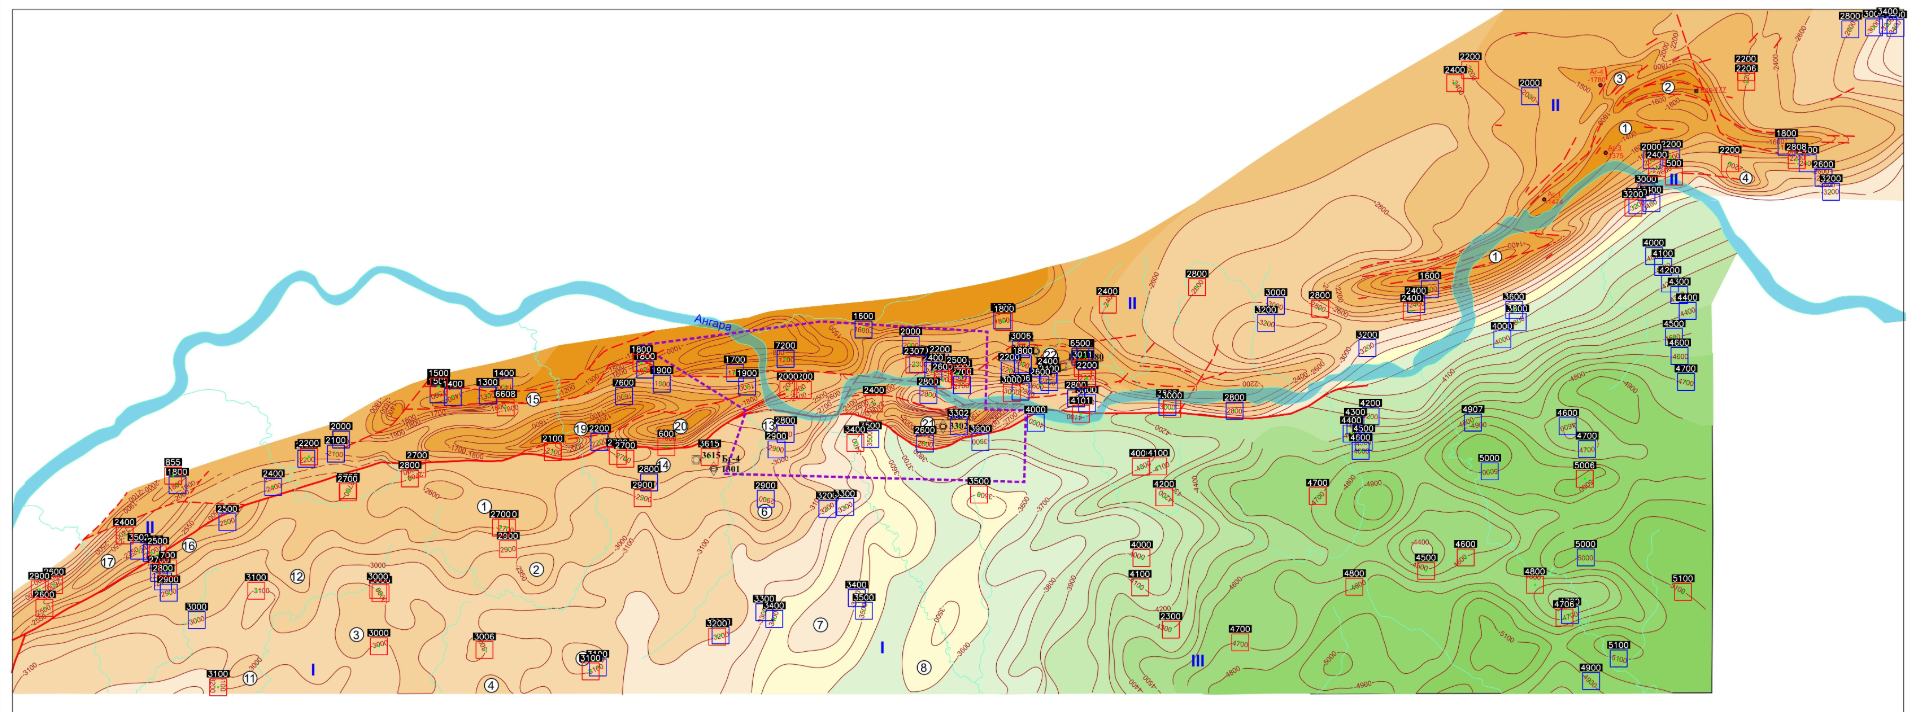

В результате мы получили соответствие цвет-высота для каждого цвета кластера. Пользователь может открыть этот файл, оценить, адекватны ли цвета и их высоты, поправить что-то внутри этого файла (при необходимости) и сохранить. Теперь на основе этого создадим .txt файл для всех пикселей карты

In [ ]:
def load_mapping(filepath):

    context = {'np': np} #создаю словарь, причем с доступным модулем numpy из-за особенностей записи
    with open(filepath, 'r', encoding='utf-8') as f: #encoding='utf-8' важно для русских комментариев
        content = f.read()
    try:
        exec(content, context) #тут интересно - я выполняю содержимое файла как Python-код (выше я говорила, что запишу в файл соотношения в формате словаря)
        mapping_raw = context.get('COLOR_HEIGHT_MAPPING', {}) #после выполнения exec() в context появляется переменная COLOR_HEIGHT_MAPPING, эта строка извлекает её
    except Exception as e:
        print(f"Ошибка чтения файла: {e}")
        return None

    clean_mapping = {}
    for color_tuple, height in mapping_raw.items(): #перебираем пары цвет-высота
        clean_color = tuple(int(c) for c in color_tuple)
        clean_mapping[clean_color] = int(height)

    return clean_mapping

In [ ]:
def generate_itog_file_with_mask(image_path, mapping, mask="background_mask.npy", output_txt="itog.txt"):

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    background_mask = np.load(mask) #загрузим маску фона
    mask_flat = background_mask.reshape(-1) #преобразуем в 1D

    #KDTree
    known_colors = list(mapping.keys()) #цвета кластеров
    known_heights = list(mapping.values()) #глубины

    tree = KDTree(known_colors) #строю k-мерное дерево для быстрого поиска ближайшего цвета

    pixels = img_rgb.reshape(-1, 3) #преобразую изображение так, что каждая строка это цвет пикселя

    distances, indices = tree.query(pixels, k=1) #query для каждого пикселя находит индекс ближайшего цвета

    #записываемм результаты
    with open(output_txt, "w", encoding="utf-8") as f:
        f.write("x, y, z\n")

        for i, idx in enumerate(indices):
            # если это под маску попадает - пропускаем пиксель
            if mask_flat[i]:
                continue

            height = known_heights[idx] #по индексу цвета получим глубину
            x = i % w #остаток от деления даёт координату x
            y = i // w #целочисленное деление даёт координату y

            f.write(f"{x},{y},{height}\n") #записываю в файл

## Валидация решения

Для валидации решения я пробую восстановить карту по итоговому файлу

In [ ]:
def verify_result(itog_path, mapping, width, height):

    height_to_color = {} #начиинаю с создания словаря глубина-цвет, чтобы по значению высоты из файла найти цвет

    for color, h_val in mapping.items():
        if h_val not in height_to_color: #если глубина пока еще не в словаре, добавим к ней цвет
            height_to_color[h_val] = color

    reconstructed_img = np.full((height, width, 3), 255, dtype=np.uint8) #создаю белое изображение такого же размера

    try:
        with open(itog_path, "r") as f:
            header = f.readline()

            for line in f:
                parts = line.strip().split(',') #в строке 3 значения - x, y, z

                if len(parts) != 3: #вдруг кто-то (например, пользователь в будущем) что-то добавил в файл, в итоге у нас не 3 элемента (x, y, z), а что-то другое. тогда пропускаем это, чтобы ничего не сломать
                    continue

                x, y, z = int(parts[0]), int(parts[1]), int(parts[2])
                color = height_to_color.get(z, (0, 0, 0)) #из словаря по глубине нахожу цвет. иначе использую черный, чтобы сразу увидеть это на проверочной карте
                color_bgr = (color[2], color[1], color[0])

                #проверка, что координаты находятся внутри изображения (как и везде, это прописала)
                if 0 <= x < width and 0 <= y < height:
                    reconstructed_img[y, x] = color_bgr #устанавливаю цвет пикселя

        cv2.imwrite("verification_map.png", reconstructed_img)

        plt.figure(figsize=(10, 10))
        plt.title("Восстановленная карта из TXT")
        plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Ошибка: {e}")


In [ ]:
mapping = load_mapping("color_height_mapping.txt") #загружаю словарь соответствия цвет-высота из файла

In [ ]:
if mapping: #если mapping загрузилось
  image_file = "cleaned_heatmap_quantized.png" #"cleaned_heatmap.png"
  temp_img = cv2.imread(image_file)

  h, w = temp_img.shape[:2]
  generate_itog_file_with_mask(image_file, mapping, mask="background_mask.npy", output_txt="itog1.txt") #получаю итоговый файл с координатами и высотами
  verify_result("itog1.txt", mapping, width=w, height=h) #по этому файлу теперь создам карту

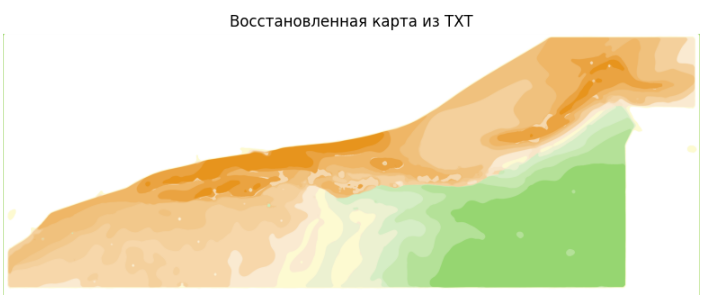

In [ ]:
if mapping: #если mapping загрузилось
  image_file = "cleaned_heatmap.png" #"cleaned_heatmap_quantized.png"
  temp_img = cv2.imread(image_file)

  h, w = temp_img.shape[:2]
  generate_itog_file_with_mask(image_file, mapping, mask="background_mask.npy", output_txt="itog.txt") #получаю итоговый файл с координатами и высотами
  verify_result("itog.txt", mapping, width=w, height=h) #по этому файлу теперь создам карту

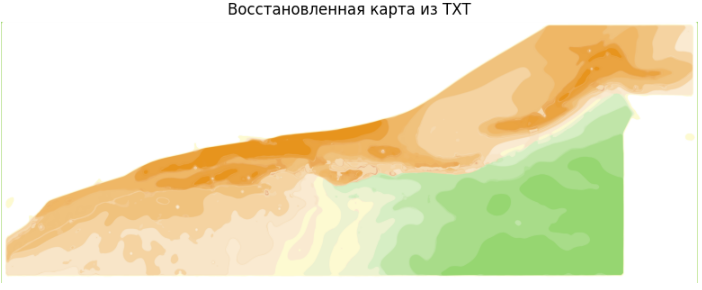

Интересное замечание!  

Подход может немного различаться в зависимости от того, какое изображение я подаю на вход функции generate_itog_file_with_mask.  
Есть 2 варианта:  
1. cleaned_heatmap_quantized.png - карта, которая содержит только цвета кластеров  
2. cleaned_heatmap.png - карта, которая все еще содержит градиенты и исходные оттенки, она не приведена к единым цветам геозон  

В первом случае (cleaned_heatmap_quantized.png) нам бы не потребовался KDTree. Почему? Пиксели этого изображение уже имеют только цвета заданных кластеров. Эти цвета прописаны в словаре mapping. В результате, когда я прохожу по каждому пикселю этого файла, я уже знаю, что его цвет точно записан в словарь, а значит и содержит высоту. Соответственно нет необходимости искать похожий цвет пикселя с KDTree, так как уже все цвета мы знаем.  

Во втором случае (cleaned_heatmap.png) нам нужен KDTree. Почему? Пиксели этого изображения не имеют цвета строго в соответствии с кластерами, а значит при анализе каждого пикселя нам нужно с помощью KDTree найти похожий цвет кластера из словаря mapping. Да, этот подход сложнее. Но его использование объяснимо следующим:  

Даже на кластеризированной карте (первый подход) цвета могут незначительно отличаться из-за:
- округлений при преобразовании типов данных
- артефактов сжатия изображений
- того, что mapping создаётся из СРЕДНИХ цветов областей вокруг цифр (например, если цифра находится на границе цветовых зон, средний цвет оказывается промежуточным не из кластера)

Также использование cleaned_heatmap.png с KDTree объяснимо тем, что это в целом более реалистично, ведь карта (отсканированная) всегда будет иметь градиенты и разные оттенки одного цвета.